[View in Colaboratory](https://colab.research.google.com/github/rishabh-vij/Fast.ai_MOOC/blob/master/Week%207/CNN_Resnet_Scratch.ipynb)

## Cifar10 CNN models and resnet from scratch

In [0]:
#!pip install opencv-python
#!apt update && apt install -y libsm6 libxext6
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
! pip3 install fastai
#!pip3 install torchvision
#! pip install torchtext

In [0]:
#! wget http://pjreddie.com/media/files/cifar.tgz
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!tar -xvzf ./cifar.tgz


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
ls ./cifar

labels.txt  models/  test/  tmp/  train/


In [0]:
import os
import glob
import shutil
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cwd = os.getcwd()
train_path = cwd + '/cifar/train/'
# go through classes and make a directory for each one
for class_now in classes:
    path_now = train_path + class_now
    if not os.path.exists(path_now):
        os.makedirs(path_now)
# go through classes and match them with file names
# file names are e.g. '123_frog.png' so glob picks out all the e.g. frog files
for class_now in classes:
    identifier = train_path + '*' + class_now + '.png'
    class_files = glob.glob(identifier)
    file_destination = train_path + class_now
    # move all frog files to proper class directory
    for file_to_move in class_files:
        shutil.move(file_to_move, file_destination)

# do all the same but now for the test data
test_path = cwd + '/cifar/test/'
for class_now in classes:
    path_now = test_path + class_now
    if not os.path.exists(path_now):
        os.makedirs(path_now)
for class_now in classes:
    identifier = test_path + '*' + class_now + '.png'
    class_files = glob.glob(identifier)
    file_destination = test_path + class_now
    for file_to_move in class_files:
        shutil.move(file_to_move, file_destination)

In [34]:
ls cifar/test

airplane/  automobile/  bird/  cat/  deer/  dog/  frog/  horse/  ship/  truck/


In [7]:
from fastai.conv_learner import *
PATH = "cifar/"
os.makedirs(PATH,exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

labels.txt  models  test  tmp  train
airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [0]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))


In [0]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [0]:
bs=256

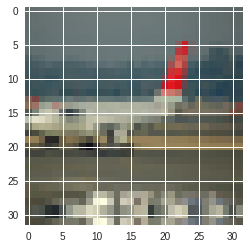

In [22]:
# having a look at the data
data = get_data(32,bs)
x,y=next(iter(data.trn_dl))
plt.imshow(data.trn_ds.denorm(x)[5]);

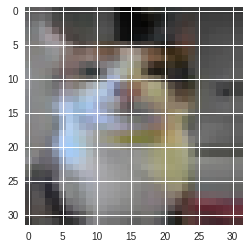

In [21]:
plt.imshow(data.trn_ds.denorm(x)[3]);

**The data looks pretty difficult to interpret**

## Fully connected CNN from scratch

In [0]:
class cnnNet(nn.Module):
  def __init__(self,layers,c):
    super().__init__()
    self.layers=nn.ModuleList([nn.Conv2d(layers[i],layers[i+1],kernel_size=3, stride=2,padding=1)for i in range(len(layers)-1)])
    self.pool=nn.AdaptiveMaxPool2d(1)
    self.out=nn.Linear(layers[-1],c)
 
  def forward(self,x):
    for l in self.layers: x=F.relu(l(x))
    x=self.pool(x)
    x=x.view(x.size(0),-1)
    return F.log_softmax(self.out(x),dim=-1)

In [0]:
learn= ConvLearner.from_model_data(cnnNet([3,20,40,80],10),data)

In [25]:
learn,learn.summary()

(cnnNet(
   (layers): ModuleList(
     (0): Conv2d (3, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): Conv2d (20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (2): Conv2d (40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   )
   (pool): AdaptiveMaxPool2d(output_size=1)
   (out): Linear(in_features=80, out_features=10)
 ),
 OrderedDict([('Conv2d-1',
               OrderedDict([('input_shape', [-1, 3, 32, 32]),
                            ('output_shape', [-1, 20, 16, 16]),
                            ('trainable', True),
                            ('nb_params', 560)])),
              ('Conv2d-2',
               OrderedDict([('input_shape', [-1, 20, 16, 16]),
                            ('output_shape', [-1, 40, 8, 8]),
                            ('trainable', True),
                            ('nb_params', 7240)])),
              ('Conv2d-3',
               OrderedDict([('input_shape', [-1, 40, 8, 8]),
                            ('output_sh

In [26]:
learn.lr_find()

 81%|████████  | 158/196 [00:21<00:05,  7.28it/s, loss=13.8]

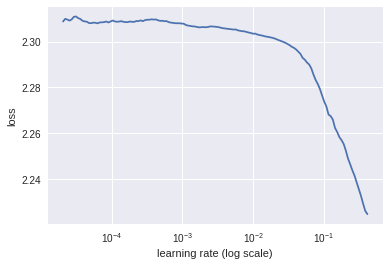

In [27]:
learn.sched.plot()

In [28]:
learn.lr_find(end_lr=100) #It is still not able to find the lr as end_lr is set to 10

 71%|███████▏  | 140/196 [00:19<00:07,  7.13it/s, loss=57.4]

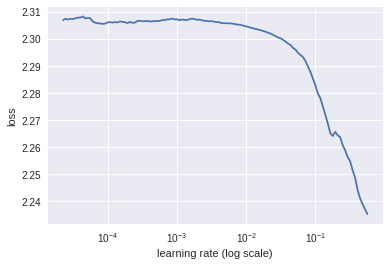

In [29]:
learn.sched.plot()

In [30]:
learn.fit(1e-1,2)

epoch      trn_loss   val_loss   accuracy   
    0      1.708553   1.628969   0.4062    
    1      1.519487   1.489863   0.4611    


[array([1.48986]), 0.4611]

In [31]:
learn.fit(1e-1, 3, cycle_len=1,cycle_mult=2)


epoch      trn_loss   val_loss   accuracy   
    0      1.39069    1.299726   0.5348    
    1      1.350521   1.270105   0.5436    
 77%|███████▋  | 151/196 [00:20<00:06,  7.30it/s, loss=1.24]

    2      1.222021   1.174412   0.5811    
    3      1.33456    1.358752   0.5105    
    4      1.253822   1.199736   0.5668    
 49%|████▉     | 97/196 [00:13<00:14,  6.97it/s, loss=1.19]

    5      1.147252   1.126584   0.6045    
    6      1.075746   1.053092   0.6289    


[array([1.05309]), 0.6289]

## BatchNorm from scratch
**We use batchnorm to normalize each layer**

In [0]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [0]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)


In [35]:
learn.fit(3e-2, 2)


epoch      trn_loss   val_loss   accuracy   
    0      1.513634   1.358708   0.5072    
    1      1.272863   1.169354   0.5859    


[array([1.16935]), 0.5859]

In [36]:
learn.fit(3e-2, 3,cycle_len=1,cycle_mult=2)


epoch      trn_loss   val_loss   accuracy   
    0      1.07721    1.009225   0.6377    
    1      1.055924   0.945078   0.6647    
 40%|███▉      | 78/196 [00:12<00:18,  6.50it/s, loss=0.992]

    2      0.930677   0.903264   0.6823    
    3      0.992281   0.943119   0.6672    
 96%|█████████▋| 189/196 [00:28<00:01,  6.53it/s, loss=0.895]

    4      0.891233   0.870568   0.6929    
    5      0.818027   0.776439   0.7291    
    6      0.776424   0.78485    0.7321    


[array([0.78485]), 0.7321]

## Resnet from scratch

In [0]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)


In [40]:
wd=1e-5
learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      1.554694   1.416668   0.4859    
    1      1.341609   1.310673   0.5296    


[array([1.31067]), 0.5296]

In [43]:
learn.fit(1e-2, 3, cycle_len=1,cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      1.133091   1.065738   0.6209    
    1      1.090187   1.006463   0.6461    
 24%|██▍       | 47/196 [00:13<00:41,  3.59it/s, loss=1.04]

    2      0.968318   0.964641   0.6562    
    3      0.999234   0.943355   0.6647    
 71%|███████   | 139/196 [00:30<00:12,  4.49it/s, loss=0.922]

    4      0.910268   0.878829   0.6952    
    5      0.81344    0.812274   0.711     
 89%|████████▉ | 174/196 [00:38<00:04,  4.56it/s, loss=0.766]

    6      0.779276   0.791134   0.7224    


[array([0.79113]), 0.7224]

**Simple BatchNorm and resnet are giving around equal accuracy, infact BatchNorm seems to be working slightly better**

In [44]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
metrics.log_loss(y,preds), accuracy_np(preds,y)


(0.7468485474222892, 0.7417)

**So we get around 75% accuracy with just around 9 epochs. There is definately scope for improvement by just training a little longer**

##End.